# can you write some python code using agentpy for a simple implementation of rodgers' diffusion of innovaiton - o1

In [3]:
import agentpy as ap
import matplotlib.pyplot as plt
import numpy as np

class InnovationAgent(ap.Agent):
    def setup(self):
        self.adopted = False
        self.category = category_distribution(self.id, self.model.p.population)

    def adopt_innovation(self):
        if not self.adopted:
            if self.category == 'innovator':
                self.adopted = True
            elif self.category in ['early_adopter', 'early_majority', 'late_majority']:
                neighbors = self.model.network.neighbors(self)
                adopters = sum(1 for n in neighbors if n.adopted)
                threshold = self.model.thresholds[self.category]
                if len(neighbors) > 0 and adopters / len(neighbors) >= threshold:
                    self.adopted = True
            elif self.category == 'laggard':
                neighbors = self.model.network.neighbors(self)
                adopters = sum(1 for n in neighbors if n.adopted)
                if len(neighbors) > 0 and adopters / len(neighbors) >= self.model.thresholds['laggard']:
                    self.adopted = True

class DiffusionModel(ap.Model):
    def setup(self):
        self.agents = ap.AgentList(self, self.p.population, InnovationAgent)
        self.network = ap.Network(agents=self.agents, connections=self.p.avg_degree)
        self.network.add_edges(self.agents)
        self.agents.setup()

        self.category_distribution = self.p.category_distribution
        self.thresholds = {
            'innovator': self.p.innovator_threshold,
            'early_adopter': self.p.early_adopter_threshold,
            'early_majority': self.p.early_majority_threshold,
            'late_majority': self.p.late_majority_threshold,
            'laggard': self.p.laggard_threshold
        }

    def step(self):
        for agent in self.agents:
            agent.adopt_innovation()

    def update(self):
        adopted_agents = sum(1 for a in self.agents if a.adopted)
        self.record('Adopted', adopted_agents)

    def end(self):
        self.record('Final Adoption Rate', sum(1 for a in self.agents if a.adopted) / self.p.population)

def category_distribution(agent_id, population):
    categories = ['innovator', 'early_adopter', 'early_majority', 'late_majority', 'laggard']
    probabilities = [0.05, 0.1, 0.35, 0.35, 0.15]
    assignment = np.random.choice(categories, p=probabilities, size=population)
    return assignment[agent_id]

parameters = {
    'population': 100,
    'avg_degree': 4,
    'steps': 20,
    'category_distribution': category_distribution,
    'innovator_threshold': 0.0,
    'early_adopter_threshold': 0.1,
    'early_majority_threshold': 0.3,
    'late_majority_threshold': 0.5,
    'laggard_threshold': 0.8
}

# exp = ap.Experiment(DiffusionModel, parameters, iterations=1)
# results = exp.run()

model = DiffusionModel(parameters)
results = model.run()

plt.plot(results['t'], results['Adopted'])
plt.title('Diffusion of Innovation Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Number of Adopters')
plt.show()

IndexError: index 100 is out of bounds for axis 0 with size 100

# from the first post of the notebook

Completed: 100 steps
Run time: 0:00:00.021098
Simulation finished


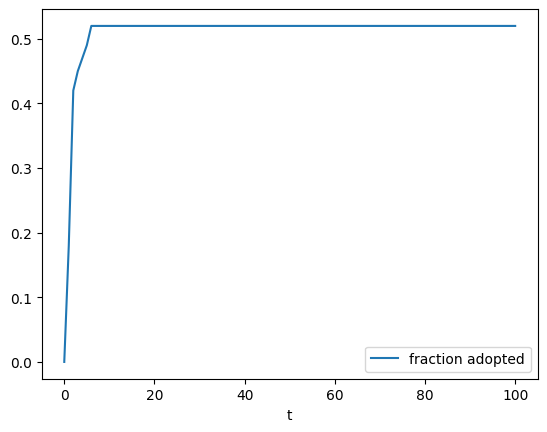

In [39]:
# Model design
import agentpy as ap
import networkx as nx
import numpy as np
import random 

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns
import IPython

class InnovationAgent(ap.Agent):
    def setup(self):
        """
        Initializes the agent's adoption state and assigns it to a category based on predefined probabilities.
        """
        # Everyone starts as having not adopted the technology
        self.adopted = False

        # Select a category for the agent using the given probabilities
        rng = np.random
        self.category_idx = rng.choice(len(self.p.categories), p=self.p.probabilities)
        self.category = self.p.categories[self.category_idx]

    def num_adopted_neighbors(self):
        """
        Calculates the number of neighboring agents who have adopted the innovation.
        Returns:
            int: The count of neighbors who have adopted.
        """
        # Get the neighbors of the current agent
        neighbors = self.network.neighbors(self)
        
        # Check adoption status for each neighbor
        adopted = [n.adopted for n in neighbors]
        
        # Count the number of adopters
        return sum(adopted)

    def neighbor_adopted_frac(self):
        """
        Calculates the fraction of neighboring agents who have adopted the innovation.
        Returns:
            float: Fraction of neighbors who have adopted, or 0 if there are no neighbors.
        """
        # Get the neighbors of the current agent
        neighbors = self.network.neighbors(self)
        
        # Check adoption status for each neighbor
        adopted = [n.adopted for n in neighbors]
        len_neighbors = len(adopted)

        # Handle case where there are no neighbors
        if len_neighbors == 0:
            return 0

        # Calculate and return the fraction of adopters
        num_adopters = sum(adopted)
        return num_adopters / len_neighbors

    def adopt_innovation(self):
        """
        Determines whether the agent adopts the innovation based on its category
        and the adoption status of its neighbors.
        """
        # Only proceed if the agent has not already adopted the innovation
        if not self.adopted:
            # Innovators adopt unconditionally
            if self.category == 'innovator':
                self.adopted = True
            # Other categories adopt based on a threshold of neighbor adoption
            elif self.category in ['early_adopter', 'early_majority', 'late_majority', 'laggard']:
                # Calculate the fraction of neighbors who have adopted
                adopted_frac = self.neighbor_adopted_frac()

                # Get the threshold for the agent's category
                threshold = self.p.thresholds[self.category_idx]

                # Adopt if the fraction meets or exceeds the threshold
                if adopted_frac >= threshold:
                    self.adopted = True


class InnovationModel(ap.Model):
    """
    This class represents the overall model for innovation diffusion. It manages the setup,
    simulation steps, and final results.
    """

    def setup(self):
        """
        Initializes the network and agents for the simulation. A small-world network is
        created using the Watts-Strogatz model, and agents are assigned to it.
        """
        graph = nx.watts_strogatz_graph(
            self.p.population,
            self.p.number_of_connections,
            self.p.network_rewire_probability,
        )

        # Create agents and a network
        self.agents = ap.AgentList(self, self.p.population, InnovationAgent)
        self.network = self.agents.network = ap.Network(self, graph)
        self.network.add_agents(self.agents, self.network.nodes)

    def update(self):
        """
        Calculates the fraction of agents who have adopted the innovation and records it.
        Stops the simulation if all agents have adopted.
        """
        frac_adopted = sum(1 for a in self.agents if a.adopted) / self.p.population
        self.record("fraction adopted", frac_adopted)

        # Stop if everyone has adopted the tech
        if frac_adopted == 1:
            self.stop()

    def step(self):
        """
        Executes a single step of the simulation. During each step, agents decide
        whether to adopt the innovation based on their category and network connections.
        """
        for agent in self.agents:
            agent.adopt_innovation() # Agents adopt innovations based on their category and network connections
    
    def end(self):
        """
        Finalizes the simulation. Additional computations or outputs can be added here if needed.
        """
        pass

parameters = {
    'population': 100,
    "categories": ['innovator', 'early_adopter', 'early_majority', 'late_majority', 'laggard'],
    "probabilities": [0.05, 0.1, 0.35, 0.35, 0.15],
    "thresholds": [0.0, 0.1, 0.25, 0.5, 0.9],
    "number_of_connections": 4,
    "network_rewire_probability": 0.1,
    "steps":100,
}

model = InnovationModel(parameters)
results = model.run()

%matplotlib inline
data = results.variables.InnovationModel
ax = data.plot()

In [40]:
stacked_traces.append(data["fraction adopted"])

Text(0, 0.5, 'fraction of population adopted')

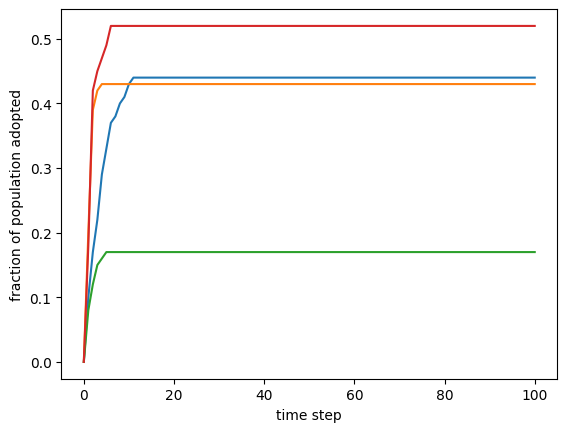

In [42]:
%matplotlib inline
for trace in stacked_traces:
    plt.plot(trace)
plt.xlabel("time step")
plt.ylabel("fraction of population adopted")

In [45]:
data.to_json()

'{"fraction adopted":{"0":0.0,"1":0.18,"2":0.42,"3":0.45,"4":0.47,"5":0.49,"6":0.52,"7":0.52,"8":0.52,"9":0.52,"10":0.52,"11":0.52,"12":0.52,"13":0.52,"14":0.52,"15":0.52,"16":0.52,"17":0.52,"18":0.52,"19":0.52,"20":0.52,"21":0.52,"22":0.52,"23":0.52,"24":0.52,"25":0.52,"26":0.52,"27":0.52,"28":0.52,"29":0.52,"30":0.52,"31":0.52,"32":0.52,"33":0.52,"34":0.52,"35":0.52,"36":0.52,"37":0.52,"38":0.52,"39":0.52,"40":0.52,"41":0.52,"42":0.52,"43":0.52,"44":0.52,"45":0.52,"46":0.52,"47":0.52,"48":0.52,"49":0.52,"50":0.52,"51":0.52,"52":0.52,"53":0.52,"54":0.52,"55":0.52,"56":0.52,"57":0.52,"58":0.52,"59":0.52,"60":0.52,"61":0.52,"62":0.52,"63":0.52,"64":0.52,"65":0.52,"66":0.52,"67":0.52,"68":0.52,"69":0.52,"70":0.52,"71":0.52,"72":0.52,"73":0.52,"74":0.52,"75":0.52,"76":0.52,"77":0.52,"78":0.52,"79":0.52,"80":0.52,"81":0.52,"82":0.52,"83":0.52,"84":0.52,"85":0.52,"86":0.52,"87":0.52,"88":0.52,"89":0.52,"90":0.52,"91":0.52,"92":0.52,"93":0.52,"94":0.52,"95":0.52,"96":0.52,"97":0.52,"98":0.52

In [33]:
stacked_traces

[t
 0      0.00
 1      0.10
 2      0.17
 3      0.22
 4      0.29
        ... 
 96     0.44
 97     0.44
 98     0.44
 99     0.44
 100    0.44
 Name: fraction adopted, Length: 101, dtype: float64,
 t
 0      0.00
 1      0.20
 2      0.39
 3      0.42
 4      0.43
        ... 
 96     0.43
 97     0.43
 98     0.43
 99     0.43
 100    0.43
 Name: fraction adopted, Length: 101, dtype: float64]

In [25]:
for agent in model.agents:
    print("{},{}".format(agent.adopted,agent.category))

False,laggard
False,late_majority
False,late_majority
False,late_majority
False,laggard
False,laggard
False,early_majority
False,late_majority
False,late_majority
False,late_majority
True,early_adopter
False,laggard
True,early_majority
False,laggard
True,early_majority
True,innovator
True,early_majority
True,late_majority
True,innovator
True,late_majority
True,late_majority
True,late_majority
False,laggard
False,late_majority
False,early_majority
False,late_majority
False,early_majority
False,early_majority
False,late_majority
False,early_majority
False,late_majority
False,early_adopter
False,late_majority
False,early_majority
False,late_majority
False,early_majority
False,early_majority
False,early_majority
False,laggard
False,laggard
False,late_majority
False,late_majority
False,early_majority
False,early_majority
False,late_majority
False,early_adopter
False,late_majority
True,early_majority
False,laggard
True,early_majority
True,innovator
True,late_majority
True,late_majority
True,

Completed: 100 steps
Run time: 0:00:00.031872
Simulation finished


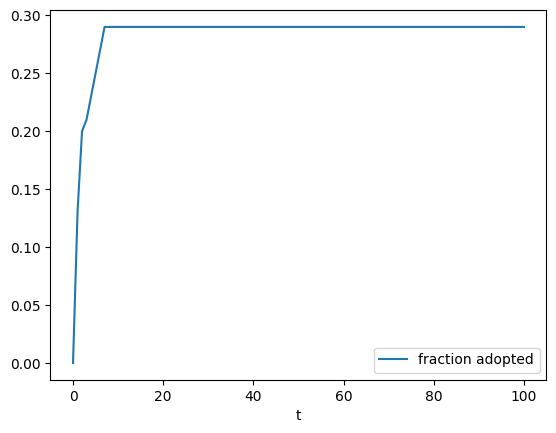

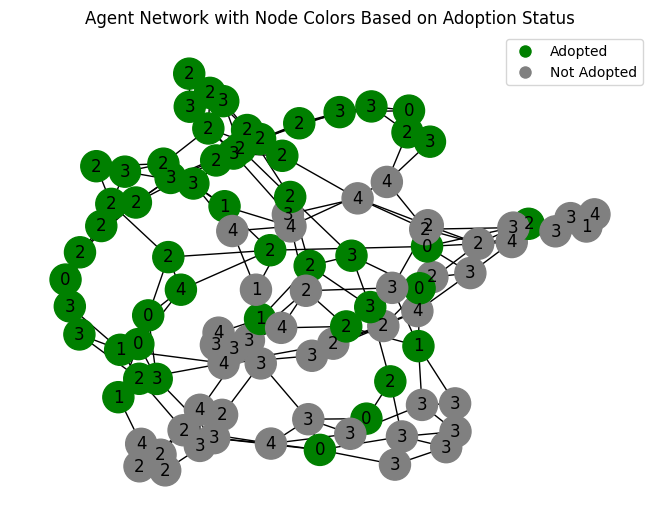

In [80]:
%matplotlib inline  
# Enable interactive widgets for matplotlib (e.g., zooming and panning).

# Get the network and agent data from the model.
network = model.network  # Retrieve the network structure from the model.
adopted_states = [agent.adopted for agent in model.agents]  # Extract the adoption status (True/False) for all agents.

# Define node colors based on the adopted parameter.
# Nodes representing agents with 'adopted = True' will be red, otherwise black.
node_colors = ['green' if adopted else 'gray' for adopted in adopted_states]

# Generate labels for nodes based on the agent's category index.
# Each node is labeled with its corresponding agent's category index as a string.
# labels = {agent:str(agent.category_idx) for agent in model.agents}
# labels = {i: labels[i] for i in range(len(labels))}  # Map labels to node indices for visualization.

# Define the layout of the graph using the spring layout.
pos = nx.spring_layout(network.graph)  # Position nodes using a force-directed layout algorithm.

# Draw the network graph using NetworkX's `draw` method.
nx.draw(
    network.graph,         # The graph to draw.
    pos,                   # Node positions.
    node_color=node_colors,  # Colors of the nodes based on adoption status.
    with_labels=False,     # Whether to show labels on the nodes (currently disabled).
    node_size=500          # Size of the nodes in the graph.
)
nx.draw_networkx_labels(network.graph, pos, labels=labels,)

# Add a legend to explain node colors.
# The legend will have two entries: one for 'Adopted' (red) and one for 'Not Adopted' (black).
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='Adopted', markerfacecolor='green', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Not Adopted', markerfacecolor='gray', markersize=10)
])

# Add a title to the plot for better understanding.
plt.title("Agent Network with Node Colors Based on Adoption Status")

# Display the graph.
plt.show()

In [72]:
labels = [str(agent.category_idx) for agent in model.agents]
labels = {node:str(labels[i]) for i,node in enumerate(model.network.nodes)}
# for i,node in enumerate(model.network.nodes):
#     print(node,str(labels[i]))

# Enhance model with economic elements

In [39]:
# Model design
import agentpy as ap
import networkx as nx
import numpy as np
import random 

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns
import IPython

class InnovationAgent(ap.Agent):
    def setup(self):
        """
        Initializes the agent's adoption state, assigns it to a category, and sets its budget.
        """
        self.adopted = False

        # Assign category and probabilities
        rng = np.random
        self.category_idx = rng.choice(len(self.p.categories), p=self.p.probabilities)
        self.category = self.p.categories[self.category_idx]

        # Assign random budget for the agent
        self.money = rng.uniform(0, 200)  # Example range

    def can_use_ai(self):
        """
        Checks if the agent can use AI resources based on their money and availability.
        Returns:
            bool: True if the agent can use AI, False otherwise.
        """
        return (self.money >= self.p.ai_cost) and (self.model.ai_resources > 0)

    def num_adopted_neighbors(self):
        """
        Counts the number of neighboring agents who have adopted the innovation.
        """
        neighbors = self.network.neighbors(self)
        return sum(n.adopted for n in neighbors)

    def neighbor_adopted_frac(self):
        """
        Calculates the fraction of neighboring agents who have adopted the innovation.
        Returns:
            float: Fraction of adopters or 0 if there are no neighbors.
        """

        # Get the neighbors of the current agent
        neighbors = self.network.neighbors(self)
        
        # Check adoption status for each neighbor
        adopted = [n.adopted for n in neighbors]
        len_neighbors = len(adopted)

        # Handle case where there are no neighbors
        if len_neighbors == 0:
            return 0

        # Calculate and return the fraction of adopters
        num_adopters = sum(adopted)
        return 1.0 * num_adopters / len_neighbors

    def adopt_use_contribute(self):
        """
        Handles the agent's behavior: adopting, using, or contributing to AI resources.
        """
        # Add money probabilistically every turn
        
        # self.money += np.random.uniform(1,1.1)
        self.money += np.random.uniform(self.p.standard_money_gain_min, self.p.standard_money_gain_max)
        
        # decide whether to use
        if self.adopted and self.can_use_ai():
            self.use_technology()
        
        # Decide whether to contribute
        if ((np.random.uniform() < self.p.contributor_fraction)) or (self.category == "innovator"):
            self.contribute_to_ai()

        if not self.adopted:
            # Innovators adopt unconditionally if they can afford AI
            if self.category == 'innovator' and self.can_use_ai():
                self.adopted = True

            # Other categories adopt based on a threshold and affordability
            elif self.category in ['early_adopter', 'early_majority', 'late_majority', 'laggard']:
                adopted_frac = self.neighbor_adopted_frac()
                threshold = self.p.thresholds[self.category_idx]

                if adopted_frac >= threshold and self.can_use_ai():
                    self.adopted = True
                    self.use_technology()

    def use_technology(self):
        """
        Deducts the cost of using AI and reduces global AI resources.
        """
        # print("used ai resource")
        self.money -= self.p.ai_cost
        self.model.ai_resources -= 1

    def contribute_to_ai(self):
        """
        Generates and contributes additional money and AI resources to the system.
        """
        generated_money = np.random.uniform(self.p.ai_money_gain_min, self.p.ai_money_gain_max)
        generated_resources = np.random.randint(self.p.resource_gain_min, self.p.resource_gain_max + 1)
        # print("{} resources added".format(generated_resources))

        self.money += generated_money
        self.model.ai_resources += generated_resources

def gini(x):

    """ Calculate Gini Coefficient """
    # By Warren Weckesser https://stackoverflow.com/a/39513799
    
    x = np.array(x)
    mad = np.abs(np.subtract.outer(x, x)).mean()  # Mean absolute difference
    rmad = mad / np.mean(x)  # Relative mean absolute difference
    return 0.5 * rmad 

class InnovationModel(ap.Model):
    """
    This class represents the overall model for innovation diffusion. It manages the setup,
    simulation steps, and final results.
    """

    def setup(self):
        """
        Initializes the network and agents for the simulation. A small-world network is
        created using the Watts-Strogatz model, and agents are assigned to it.
        """
        graph = nx.watts_strogatz_graph(
            self.p.population,
            self.p.number_of_connections,
            self.p.network_rewire_probability,
        )

        # Create agents and a network
        self.agents = ap.AgentList(self, self.p.population, InnovationAgent)
        self.network = self.agents.network = ap.Network(self, graph)
        self.network.add_agents(self.agents, self.network.nodes)

        # Initialize AI resources
        self.ai_resources = self.p.total_ai_resources

    def update(self):
        """
        Calculates the fraction of agents who have adopted the innovation and records it.
        Stops the simulation if all agents have adopted.
        """
        num_adopted = sum(1 for a in self.agents if a.adopted)
        frac_adopted = num_adopted / self.p.population

        self.record("num_adopted", num_adopted)
        self.record("fraction_adopted", frac_adopted)

        remaining_resources = self.ai_resources
        total_money = sum(agent.money for agent in self.agents)

        # Record key metrics
        self.record('remaining_resources', remaining_resources)
        self.record('total_money', total_money)
        self.record('Gini Coefficient', gini(self.agents.money))

        
        # Stop if everyone has adopted the tech
        if frac_adopted == 1:
            self.stop()

    def step(self):
        """
        Executes a single step of the simulation. During each step, agents decide
        whether to adopt the innovation based on their category and network connections.
        """
        for agent in self.agents:
            agent.adopt_use_contribute() # Agents adopt innovations based on their category and network connections
    
    def end(self):
        """
        Finalizes the simulation. Additional computations or outputs can be added here if needed.
        """
        pass

parameters = {
    'population': 10000,
    'categories': ['innovator', 'early_adopter', 'early_majority', 'late_majority', 'laggard'],
    'contributor_fraction':0.50, # % of adoptors contribute to tech
    'probabilities': [0.05, 0.1, 0.35, 0.35, 0.15],
    'thresholds': [0.0, 0.01, 0.25, 0.5, 0.9],
    'number_of_connections': 20,
    'network_rewire_probability': 0.05,

    'total_ai_resources': 30,  # Total AI resources available
    'ai_cost': 10,  # Cost of using AI for each adoption
    'standard_money_gain_min': -2, # Minimum money generated by normal economic output
    'standard_money_gain_max': 4, # Maximum money generated by normal economic output
    'ai_money_gain_min': 0,  # Minimum money generated by AI usage
    'ai_money_gain_max': 50,  # Maximum money generated by AI usage
    'resource_gain_min': 0,  # Minimum AI resources generated by adoption
    'resource_gain_max': 3,  # Maximum AI resources generated by adoption

    'steps': 250,
}

# model = InnovationModel(parameters)
# results = model.run()

# data = results.variables.InnovationModel
# ax = data["Gini Coefficient"].plot()
# # ax = data["fraction_adopted"].plot()
# ax = data["num_adopted"].plot()
# ax = data["remaining_resources"].plot()
# ax = data["total_money"].plot()
# plt.close()

In [14]:
gini_traces = []
for contrib in np.arange(0.0,0.6,0.1):
    parameters['contributor_fraction'] = float(contrib)
    print(parameters)
    model = InnovationModel(parameters)
    results = model.run()
    gini_traces.append(results.variables.InnovationModel["Gini Coefficient"].copy())

{'population': 10000, 'categories': ['innovator', 'early_adopter', 'early_majority', 'late_majority', 'laggard'], 'contributor_fraction': 0.0, 'probabilities': [0.05, 0.1, 0.35, 0.35, 0.15], 'thresholds': [0.0, 0.01, 0.25, 0.5, 0.9], 'number_of_connections': 20, 'network_rewire_probability': 0.05, 'total_ai_resources': 30, 'ai_cost': 10, 'standard_money_gain_min': -2, 'standard_money_gain_max': 4, 'ai_money_gain_min': 0, 'ai_money_gain_max': 50, 'resource_gain_min': 0, 'resource_gain_max': 3, 'steps': 250}
Completed: 250 steps
Run time: 0:01:02.593997
Simulation finished
{'population': 10000, 'categories': ['innovator', 'early_adopter', 'early_majority', 'late_majority', 'laggard'], 'contributor_fraction': 0.1, 'probabilities': [0.05, 0.1, 0.35, 0.35, 0.15], 'thresholds': [0.0, 0.01, 0.25, 0.5, 0.9], 'number_of_connections': 20, 'network_rewire_probability': 0.05, 'total_ai_resources': 30, 'ai_cost': 10, 'standard_money_gain_min': -2, 'standard_money_gain_max': 4, 'ai_money_gain_min': 

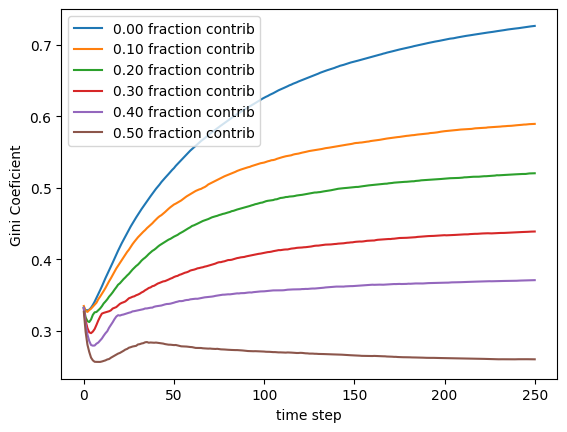

In [16]:
# ax = data["Gini Coefficient"].plot()
contrib = np.arange(0.0,0.6,0.1)
for i, trace in enumerate(gini_traces):
    plt.plot(trace, label="{:0.2f} fraction contrib".format(contrib[i]))
    plt.ylabel("Gini Coeficient")
    plt.xlabel("time step")
plt.legend()
# ax.show()

In [9]:
parameters

{'population': 10000,
 'categories': ['innovator',
  'early_adopter',
  'early_majority',
  'late_majority',
  'laggard'],
 'contributor_fraction': np.float64(0.5),
 'probabilities': [0.05, 0.1, 0.35, 0.35, 0.15],
 'thresholds': [0.0, 0.01, 0.25, 0.5, 0.9],
 'number_of_connections': 20,
 'network_rewire_probability': 0.05,
 'total_ai_resources': 30,
 'ai_cost': 10,
 'standard_money_gain_min': -2,
 'standard_money_gain_max': 4,
 'ai_money_gain_min': 0,
 'ai_money_gain_max': 50,
 'resource_gain_min': 0,
 'resource_gain_max': 3,
 'steps': 250}

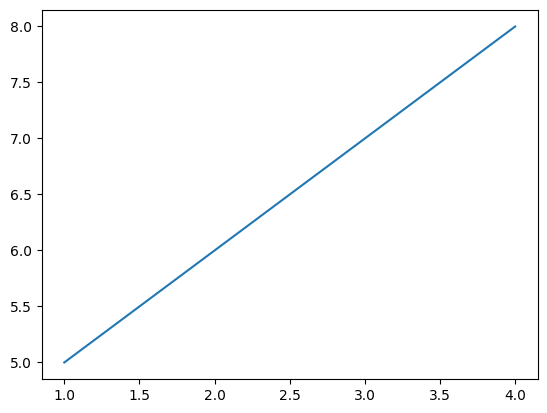

In [18]:
import matplotlib.pyplot as plt

# Create some data
x = [1, 2, 3, 4]
y = [5, 6, 7, 8]

# Plot the data
plt.plot(x, y)

# Set the labels
plt.xlabel='X-axis label'
plt.ylabel='Y-axis label'

# Display the plot
plt.show()

# api o1 generation of parameter prompts

In [33]:
o1_parameters = [
  {
    "population": 10000,
    "categories": ["innovator", "early_adopter", "early_majority", "late_majority", "laggard"],
    "contributor_fraction": 0.50,
    "probabilities": [0.05, 0.1, 0.35, 0.35, 0.15],
    "thresholds": [0.0, 0.01, 0.25, 0.5, 0.9],
    "number_of_connections": 20,
    "network_rewire_probability": 0.05,
    "total_ai_resources": 30,
    "ai_cost": 10,
    "standard_money_gain_min": -2,
    "standard_money_gain_max": 4,
    "ai_money_gain_min": 0,
    "ai_money_gain_max": 50,
    "resource_gain_min": 0,
    "resource_gain_max": 3,
    "steps": 250,
    "qualitative_description": "Base reference scenario. Balanced distribution of adopter types and moderate network rewiring to see a baseline diffusion and AI resource usage."
  },
  {
    "population": 5000,
    "categories": ["innovator", "early_adopter", "early_majority", "late_majority", "laggard"],
    "contributor_fraction": 0.30,
    "probabilities": [0.06, 0.09, 0.35, 0.35, 0.15],
    "thresholds": [0.0, 0.02, 0.2, 0.5, 0.8],
    "number_of_connections": 10,
    "network_rewire_probability": 0.1,
    "total_ai_resources": 20,
    "ai_cost": 5,
    "standard_money_gain_min": -2,
    "standard_money_gain_max": 3,
    "ai_money_gain_min": 0,
    "ai_money_gain_max": 40,
    "resource_gain_min": 0,
    "resource_gain_max": 2,
    "steps": 200,
    "qualitative_description": "Smaller population with fewer connections but slightly higher rewiring, focusing on faster spread dynamics and slightly lower AI cost to encourage AI use."
  },
  {
    "population": 15000,
    "categories": ["innovator", "early_adopter", "early_majority", "late_majority", "laggard"],
    "contributor_fraction": 0.70,
    "probabilities": [0.02, 0.08, 0.3, 0.4, 0.2],
    "thresholds": [0.0, 0.1, 0.3, 0.6, 0.9],
    "number_of_connections": 25,
    "network_rewire_probability": 0.02,
    "total_ai_resources": 50,
    "ai_cost": 10,
    "standard_money_gain_min": -3,
    "standard_money_gain_max": 4,
    "ai_money_gain_min": 0,
    "ai_money_gain_max": 60,
    "resource_gain_min": 1,
    "resource_gain_max": 3,
    "steps": 300,
    "qualitative_description": "Larger population with a higher share of contributors. Lower rewiring encourages local clustering, and a moderate AI cost with higher total AI resources."
  },
  {
    "population": 8000,
    "categories": ["innovator", "early_adopter", "early_majority", "late_majority", "laggard"],
    "contributor_fraction": 0.40,
    "probabilities": [0.05, 0.15, 0.3, 0.3, 0.2],
    "thresholds": [0.0, 0.05, 0.2, 0.45, 0.8],
    "number_of_connections": 15,
    "network_rewire_probability": 0.08,
    "total_ai_resources": 40,
    "ai_cost": 8,
    "standard_money_gain_min": -1,
    "standard_money_gain_max": 2,
    "ai_money_gain_min": 0,
    "ai_money_gain_max": 30,
    "resource_gain_min": 0,
    "resource_gain_max": 2,
    "steps": 150,
    "qualitative_description": "Balanced scenario with a bit larger fraction of early adopters. Moderate connections, slightly higher rewiring, and moderate AI usage cost."
  },
  {
    "population": 20000,
    "categories": ["innovator", "early_adopter", "early_majority", "late_majority", "laggard"],
    "contributor_fraction": 0.20,
    "probabilities": [0.07, 0.13, 0.3, 0.3, 0.2],
    "thresholds": [0.0, 0.01, 0.25, 0.5, 0.9],
    "number_of_connections": 30,
    "network_rewire_probability": 0.05,
    "total_ai_resources": 60,
    "ai_cost": 12,
    "standard_money_gain_min": -2,
    "standard_money_gain_max": 5,
    "ai_money_gain_min": 5,
    "ai_money_gain_max": 50,
    "resource_gain_min": 1,
    "resource_gain_max": 4,
    "steps": 350,
    "qualitative_description": "Large population with lower contributor fraction. More total AI resources but higher AI cost, exploring how resource constraints affect adoption."
  },
  {
    "population": 12000,
    "categories": ["innovator", "early_adopter", "early_majority", "late_majority", "laggard"],
    "contributor_fraction": 0.60,
    "probabilities": [0.03, 0.07, 0.3, 0.4, 0.2],
    "thresholds": [0.0, 0.1, 0.2, 0.5, 0.8],
    "number_of_connections": 40,
    "network_rewire_probability": 0.02,
    "total_ai_resources": 25,
    "ai_cost": 5,
    "standard_money_gain_min": -1,
    "standard_money_gain_max": 4,
    "ai_money_gain_min": 2,
    "ai_money_gain_max": 45,
    "resource_gain_min": 0,
    "resource_gain_max": 3,
    "steps": 200,
    "qualitative_description": "Moderate population, high contributor fraction. Many connections with low rewiring. Lower AI cost encourages more frequent AI adoption."
  },
  {
    "population": 30000,
    "categories": ["innovator", "early_adopter", "early_majority", "late_majority", "laggard"],
    "contributor_fraction": 0.55,
    "probabilities": [0.05, 0.1, 0.35, 0.3, 0.2],
    "thresholds": [0.0, 0.02, 0.3, 0.6, 0.85],
    "number_of_connections": 50,
    "network_rewire_probability": 0.01,
    "total_ai_resources": 80,
    "ai_cost": 15,
    "standard_money_gain_min": -2,
    "standard_money_gain_max": 6,
    "ai_money_gain_min": 0,
    "ai_money_gain_max": 70,
    "resource_gain_min": 1,
    "resource_gain_max": 5,
    "steps": 400,
    "qualitative_description": "Very large population with extensive connectivity but minimal rewiring. High total AI resources and cost to test resource trade-offs at scale."
  },
  {
    "population": 6000,
    "categories": ["innovator", "early_adopter", "early_majority", "late_majority", "laggard"],
    "contributor_fraction": 0.25,
    "probabilities": [0.1, 0.15, 0.3, 0.3, 0.15],
    "thresholds": [0.0, 0.05, 0.25, 0.55, 0.9],
    "number_of_connections": 8,
    "network_rewire_probability": 0.15,
    "total_ai_resources": 10,
    "ai_cost": 5,
    "standard_money_gain_min": -3,
    "standard_money_gain_max": 3,
    "ai_money_gain_min": 0,
    "ai_money_gain_max": 35,
    "resource_gain_min": 0,
    "resource_gain_max": 2,
    "steps": 100,
    "qualitative_description": "Smaller population with a higher rewiring rate, leading to quicker rearrangement of networks. Low initial AI resources to see if scarcity limits adoption."
  },
  {
    "population": 18000,
    "categories": ["innovator", "early_adopter", "early_majority", "late_majority", "laggard"],
    "contributor_fraction": 0.45,
    "probabilities": [0.04, 0.1, 0.33, 0.33, 0.2],
    "thresholds": [0.0, 0.01, 0.2, 0.4, 0.85],
    "number_of_connections": 20,
    "network_rewire_probability": 0.1,
    "total_ai_resources": 55,
    "ai_cost": 7,
    "standard_money_gain_min": -1,
    "standard_money_gain_max": 4,
    "ai_money_gain_min": 3,
    "ai_money_gain_max": 55,
    "resource_gain_min": 0,
    "resource_gain_max": 4,
    "steps": 300,
    "qualitative_description": "Mid-size population with moderate rewiring and a healthy pool of AI resources. Slightly less skewed adoption probabilities for earlier categories."
  },
  {
    "population": 25000,
    "categories": ["innovator", "early_adopter", "early_majority", "late_majority", "laggard"],
    "contributor_fraction": 0.35,
    "probabilities": [0.08, 0.12, 0.3, 0.35, 0.15],
    "thresholds": [0.0, 0.02, 0.25, 0.55, 0.9],
    "number_of_connections": 30,
    "network_rewire_probability": 0.07,
    "total_ai_resources": 75,
    "ai_cost": 10,
    "standard_money_gain_min": -2,
    "standard_money_gain_max": 6,
    "ai_money_gain_min": 2,
    "ai_money_gain_max": 60,
    "resource_gain_min": 1,
    "resource_gain_max": 3,
    "steps": 250,
    "qualitative_description": "Larger population aiming for a balanced approach in adoption categories. Medium network rewiring, substantial AI resources, and moderate AI cost."
  },
  {
    "population": 5000,
    "categories": ["innovator", "early_adopter", "early_majority", "late_majority", "laggard"],
    "contributor_fraction": 0.80,
    "probabilities": [0.01, 0.09, 0.35, 0.35, 0.2],
    "thresholds": [0.0, 0.01, 0.2, 0.4, 0.9],
    "number_of_connections": 5,
    "network_rewire_probability": 0.2,
    "total_ai_resources": 15,
    "ai_cost": 10,
    "standard_money_gain_min": -4,
    "standard_money_gain_max": 2,
    "ai_money_gain_min": 0,
    "ai_money_gain_max": 40,
    "resource_gain_min": 0,
    "resource_gain_max": 2,
    "steps": 200,
    "qualitative_description": "Very high fraction of contributors in a small population. Low connectivity but high rewiring for rapidly changing network structure. Higher AI cost tests commitment."
  },
  {
    "population": 28000,
    "categories": ["innovator", "early_adopter", "early_majority", "late_majority", "laggard"],
    "contributor_fraction": 0.50,
    "probabilities": [0.05, 0.1, 0.3, 0.35, 0.2],
    "thresholds": [0.0, 0.05, 0.3, 0.6, 0.95],
    "number_of_connections": 45,
    "network_rewire_probability": 0.05,
    "total_ai_resources": 90,
    "ai_cost": 18,
    "standard_money_gain_min": -2,
    "standard_money_gain_max": 5,
    "ai_money_gain_min": 4,
    "ai_money_gain_max": 80,
    "resource_gain_min": 0,
    "resource_gain_max": 5,
    "steps": 450,
    "qualitative_description": "High population, high connectivity, and large AI resource pool but also a high AI cost. Tests whether the payoff still motivates AI adoption."
  },
  {
    "population": 10000,
    "categories": ["innovator", "early_adopter", "early_majority", "late_majority", "laggard"],
    "contributor_fraction": 0.25,
    "probabilities": [0.05, 0.15, 0.25, 0.35, 0.2],
    "thresholds": [0.0, 0.02, 0.2, 0.5, 0.85],
    "number_of_connections": 20,
    "network_rewire_probability": 0.03,
    "total_ai_resources": 35,
    "ai_cost": 7,
    "standard_money_gain_min": -3,
    "standard_money_gain_max": 3,
    "ai_money_gain_min": 0,
    "ai_money_gain_max": 40,
    "resource_gain_min": 0,
    "resource_gain_max": 3,
    "steps": 300,
    "qualitative_description": "Back to a moderate population size, with fewer innovators and more early adopters. Mild rewiring. Balanced AI resource scenario with moderate cost."
  },
  {
    "population": 22000,
    "categories": ["innovator", "early_adopter", "early_majority", "late_majority", "laggard"],
    "contributor_fraction": 0.55,
    "probabilities": [0.05, 0.1, 0.35, 0.35, 0.15],
    "thresholds": [0.0, 0.01, 0.25, 0.45, 0.8],
    "number_of_connections": 35,
    "network_rewire_probability": 0.1,
    "total_ai_resources": 45,
    "ai_cost": 12,
    "standard_money_gain_min": -2,
    "standard_money_gain_max": 4,
    "ai_money_gain_min": 2,
    "ai_money_gain_max": 55,
    "resource_gain_min": 1,
    "resource_gain_max": 3,
    "steps": 350,
    "qualitative_description": "Larger population with a healthy contributor fraction. Strong middle category presence, moderate-high rewiring, and a slightly elevated AI cost."
  },
  {
    "population": 4000,
    "categories": ["innovator", "early_adopter", "early_majority", "late_majority", "laggard"],
    "contributor_fraction": 0.50,
    "probabilities": [0.15, 0.2, 0.25, 0.25, 0.15],
    "thresholds": [0.0, 0.05, 0.15, 0.4, 0.9],
    "number_of_connections": 12,
    "network_rewire_probability": 0.05,
    "total_ai_resources": 8,
    "ai_cost": 5,
    "standard_money_gain_min": -5,
    "standard_money_gain_max": 2,
    "ai_money_gain_min": 0,
    "ai_money_gain_max": 30,
    "resource_gain_min": 0,
    "resource_gain_max": 2,
    "steps": 150,
    "qualitative_description": "Smaller population heavily skewed toward early adopter types. Low AI resources create a strong competition for them. Higher chance of negative standard income."
  },
  {
    "population": 32000,
    "categories": ["innovator", "early_adopter", "early_majority", "late_majority", "laggard"],
    "contributor_fraction": 0.65,
    "probabilities": [0.03, 0.07, 0.3, 0.35, 0.25],
    "thresholds": [0.0, 0.08, 0.25, 0.5, 0.95],
    "number_of_connections": 25,
    "network_rewire_probability": 0.02,
    "total_ai_resources": 100,
    "ai_cost": 20,
    "standard_money_gain_min": -2,
    "standard_money_gain_max": 6,
    "ai_money_gain_min": 5,
    "ai_money_gain_max": 100,
    "resource_gain_min": 0,
    "resource_gain_max": 4,
    "steps": 500,
    "qualitative_description": "Large population, high contributor fraction, and very large AI resource pool—but also the highest AI cost. Tests extremes of resource abundance and cost."
  },
  {
    "population": 9000,
    "categories": ["innovator", "early_adopter", "early_majority", "late_majority", "laggard"],
    "contributor_fraction": 0.45,
    "probabilities": [0.05, 0.1, 0.3, 0.35, 0.2],
    "thresholds": [0.0, 0.02, 0.3, 0.55, 0.85],
    "number_of_connections": 18,
    "network_rewire_probability": 0.06,
    "total_ai_resources": 25,
    "ai_cost": 8,
    "standard_money_gain_min": -1,
    "standard_money_gain_max": 4,
    "ai_money_gain_min": 1,
    "ai_money_gain_max": 40,
    "resource_gain_min": 0,
    "resource_gain_max": 2,
    "steps": 250,
    "qualitative_description": "Moderate population with well-rounded probabilities. Medium connections and rewiring for steady network evolution. AI resource usage slightly encouraged by moderate cost."
  },
  {
    "population": 14000,
    "categories": ["innovator", "early_adopter", "early_majority", "late_majority", "laggard"],
    "contributor_fraction": 0.55,
    "probabilities": [0.07, 0.08, 0.3, 0.35, 0.2],
    "thresholds": [0.0, 0.03, 0.2, 0.4, 0.9],
    "number_of_connections": 22,
    "network_rewire_probability": 0.12,
    "total_ai_resources": 35,
    "ai_cost": 6,
    "standard_money_gain_min": -2,
    "standard_money_gain_max": 5,
    "ai_money_gain_min": 0,
    "ai_money_gain_max": 45,
    "resource_gain_min": 1,
    "resource_gain_max": 3,
    "steps": 300,
    "qualitative_description": "Balanced approach with a moderate population. Slightly higher rewiring fosters dynamic network shifts. AI resources remain moderate, with a modest usage cost."
  },
  {
    "population": 27000,
    "categories": ["innovator", "early_adopter", "early_majority", "late_majority", "laggard"],
    "contributor_fraction": 0.30,
    "probabilities": [0.05, 0.1, 0.35, 0.35, 0.15],
    "thresholds": [0.0, 0.02, 0.25, 0.45, 0.85],
    "number_of_connections": 28,
    "network_rewire_probability": 0.03,
    "total_ai_resources": 65,
    "ai_cost": 9,
    "standard_money_gain_min": -3,
    "standard_money_gain_max": 4,
    "ai_money_gain_min": 0,
    "ai_money_gain_max": 60,
    "resource_gain_min": 1,
    "resource_gain_max": 4,
    "steps": 350,
    "qualitative_description": "Large population, medium connectivity, and modest rewiring. Lower contributor fraction and a healthy total AI resource pool for investigating sustained adoption."
  },
  {
    "population": 10000,
    "categories": ["innovator", "early_adopter", "early_majority", "late_majority", "laggard"],
    "contributor_fraction": 0.50,
    "probabilities": [0.05, 0.1, 0.35, 0.35, 0.15],
    "thresholds": [0.0, 0.01, 0.25, 0.5, 0.9],
    "number_of_connections": 20,
    "network_rewire_probability": 0.05,
    "total_ai_resources": 30,
    "ai_cost": 10,
    "standard_money_gain_min": -2,
    "standard_money_gain_max": 4,
    "ai_money_gain_min": 0,
    "ai_money_gain_max": 50,
    "resource_gain_min": 0,
    "resource_gain_max": 3,
    "steps": 250,
    "qualitative_description": "Identical to the base scenario to facilitate direct comparison with other variations. Used as a control test to evaluate the impact of changes in other runs."
  }
]


In [34]:
import json

with open("./20_parameters_no_policy.json","w") as f:
    f.write(json.dumps(o1_parameters))

In [40]:
data_out_list = []
for parameter_dict in o1_parameters:
    model = InnovationModel(parameter_dict)
    results = model.run()

    data_out_list.append(results.variables.InnovationModel.to_json())

Completed: 250 steps
Run time: 0:01:05.429625
Simulation finished
Completed: 200 steps
Run time: 0:00:17.848951
Simulation finished
Completed: 300 steps
Run time: 0:02:50.631679
Simulation finished
Completed: 150 steps
Run time: 0:00:31.461400
Simulation finished
Completed: 350 steps
Run time: 0:04:56.908349
Simulation finished
Completed: 200 steps
Run time: 0:01:17.557102
Simulation finished
Completed: 400 steps
Run time: 0:12:51.828055
Simulation finished
Completed: 100 steps
Run time: 0:00:11.935507
Simulation finished
Completed: 300 steps
Run time: 0:03:33.754487
Simulation finished
Completed: 250 steps
Run time: 0:05:24.204500
Simulation finished
Completed: 200 steps
Run time: 0:00:20.126278
Simulation finished
Completed: 450 steps
Run time: 0:12:48.287579
Simulation finished
Completed: 300 steps
Run time: 0:01:14.758623
Simulation finished
Completed: 11 steps
Run time: 0:00:13.846920
Simulation finished
Completed: 150 steps
Run time: 0:00:10.311657
Simulation finished
Completed: 

In [42]:
with open("./data_out.json","w") as f:
    f.write(json.dumps(data_out_list))

In [43]:
with open("./qualitative_results.json","r") as f:
    qualitative_results = json.loads(f.read())

In [46]:
input_output_text = []
for i in range(len(o1_parameters)):
    input_output_text.append((o1_parameters[i]["qualitative_description"],qualitative_results[i]["Qualitative_Description"]))

In [47]:
input_output_text

[('Base reference scenario. Balanced distribution of adopter types and moderate network rewiring to see a baseline diffusion and AI resource usage.',
  'Moderate adoption, with strong uptake among early adopters and early majority. AI resources were heavily consumed, indicating high AI adoption. Moderate economic inequality, with wealth concentrated in certain groups.'),
 ('Smaller population with fewer connections but slightly higher rewiring, focusing on faster spread dynamics and slightly lower AI cost to encourage AI use.',
  'High adoption, most of the population has adopted the technology. AI resources were heavily consumed, indicating high AI adoption. Relatively equitable economic outcomes, with distributed wealth.'),
 ('Larger population with a higher share of contributors. Lower rewiring encourages local clustering, and a moderate AI cost with higher total AI resources.',
  'Low adoption, technology failed to reach widespread usage. AI resources remained largely unused, sugge

In [48]:
qualitative_results

[{'Simulation_Run': 1,
  'Qualitative_Description': 'Moderate adoption, with strong uptake among early adopters and early majority. AI resources were heavily consumed, indicating high AI adoption. Moderate economic inequality, with wealth concentrated in certain groups.'},
 {'Simulation_Run': 2,
  'Qualitative_Description': 'High adoption, most of the population has adopted the technology. AI resources were heavily consumed, indicating high AI adoption. Relatively equitable economic outcomes, with distributed wealth.'},
 {'Simulation_Run': 3,
  'Qualitative_Description': 'Low adoption, technology failed to reach widespread usage. AI resources remained largely unused, suggesting low AI adoption. Relatively equitable economic outcomes, with distributed wealth.'},
 {'Simulation_Run': 4,
  'Qualitative_Description': 'High adoption, most of the population has adopted the technology. AI resources were heavily consumed, indicating high AI adoption. Relatively equitable economic outcomes, with